In [38]:
import pandas as pd
from src.scripts import smiles
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from src.utils.utils import group_categories
import plotly.express as px

In [ ]:
smiles_df = pd.read_csv(
    "../data/BindingDB_All.tsv",
    sep="\t",
    usecols=[
        "UniProt (SwissProt) Primary ID of Target Chain",
        "DrugBank ID of Ligand",
        "Ligand SMILES",
        "IC50 (nM)",
        "Article DOI",
        "Institution",
    ],
)

/var/folders/my/2hxsh9b90b9brv55p9f5x2700000gn/T/ipykernel_6494/1080679587.py:1: DtypeWarning: Columns (9,17,23,33) have mixed types. Specify dtype option on import or set low_memory=False.
  smiles_df = pd.read_csv(


In [165]:
target = smiles_df[
    smiles_df["UniProt (SwissProt) Primary ID of Target Chain"] == "P07949"
].dropna(subset=["Ligand SMILES", "IC50 (nM)"])

In [166]:
target["Ligand Fingerprint"] = target["Ligand SMILES"].apply(smiles.get_fingerprint)

[18:47:10] Explicit valence for atom # 1 N, 4, is greater than permitted
[18:47:13] Explicit valence for atom # 35 N, 4, is greater than permitted
[18:47:13] Explicit valence for atom # 35 N, 4, is greater than permitted
[18:47:16] Explicit valence for atom # 11 N, 4, is greater than permitted
[18:47:16] Explicit valence for atom # 11 N, 4, is greater than permitted
[18:47:20] Explicit valence for atom # 1 N, 4, is greater than permitted
[18:47:21] Can't kekulize mol.  Unkekulized atoms: 3 4 7 8 9
[18:47:21] Can't kekulize mol.  Unkekulized atoms: 3 4 7 8 9
[18:47:27] Explicit valence for atom # 17 N, 4, is greater than permitted
[18:47:27] Explicit valence for atom # 17 N, 4, is greater than permitted
[18:47:27] Explicit valence for atom # 17 N, 4, is greater than permitted


In [167]:
target = target.dropna(subset=["Ligand Fingerprint", "Article DOI"])
doi_metadata = pd.read_csv(r"../src/data/metadata.csv").dropna()
target = target.merge(doi_metadata)

In [168]:
target.shape

(1088, 10)

In [169]:
# # Count occurrences of each institution
# institution_counts = target['Institution'].value_counts()

# # Filter institutions appearing at least 5 times
# target = target[target['Institution'].isin(institution_counts[institution_counts >= 10].index)]

# # Display the filtered dataframe
# target.shape

In [170]:
# Count unique years for each institution
institution_year_counts = target.groupby("Institution")["year"].nunique()

# Filter institutions with at least 5 different years
valid_institutions = institution_year_counts[institution_year_counts >= 2].index

# Filter the dataframe
target = target[target["Institution"].isin(valid_institutions)]
target.shape

(640, 10)

In [171]:
data = np.stack(target["Ligand Fingerprint"].dropna())

In [172]:
data

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [173]:
scaler = StandardScaler()
data = scaler.fit_transform(data)

In [174]:
pca = PCA(n_components=3, random_state=0)

pca_coords = pca.fit_transform(data)
target[["PC1", "PC2", "PC3"]] = pca_coords

In [175]:
in_mapping = {
    "Pfizer": [],
    "MSD": ["Dohme"],
    "Bristol-Myers Squibb": [],
    "Amgen": [],
    "Novartis": [],
    "Janssen": [],
    "Eli Lilly": ["lilly"],
    "Roche": [],
    "Incyte": [],
    "Gilead": [],
    "Bayer": [],
    "Abbott": [],
    "Scripps Research Institute": ["scripps"],
    "The Burnham Institute": ["burnham"],
    "Genentech": [],
    "GlaxoSmithKline": ["gsk"],
    "Astrazeneca": [],
    "Abbvie": [],
    "Merck": [],
    "Boehring": [],
}

f = lambda x: group_categories(
    str(x),
    in_mapping=in_mapping,
    check_key_for_in_mapping=True,
)

target["Institution"] = (
    target["Institution"].apply(f).replace("TBA", np.nan).replace("nan", np.nan)
)  # tba = to be attributed

<Axes: xlabel='PC1', ylabel='PC2'>

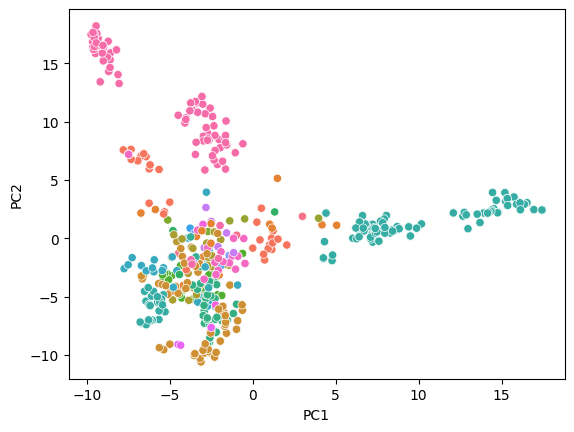

In [176]:
sns.scatterplot(
    target,
    x="PC1",
    y="PC2",
    hue="Institution",
    legend=False,
)

In [188]:
fig = px.scatter_3d(
    target.sort_values(by="year"),
    x="PC1",
    y="PC2",
    z="year",
    # size='IC50 (nM)',
    color="Institution",
    hover_data=[
        "Institution",
        # 'journal',
        # 'publisher',
        "Article DOI",
    ],
    opacity=0.7,
    template="plotly_dark",
)
fig.update_traces(marker=dict(size=2))
fig.update_layout(
    title={
        "text": "Evolution of Institutional Research on RET",
        "x": 0.5,
        "xanchor": "center",
        "yanchor": "top",
    }
)
fig.show()

In [192]:
df = px.data.gapminder()
px.scatter(
    df,
    x="gdpPercap",
    y="lifeExp",
    animation_frame="year",
    animation_group="country",
    size="pop",
    color="continent",
    hover_name="country",
    log_x=True,
    size_max=55,
    range_x=[100, 100000],
    range_y=[25, 90],
)

In [96]:
target["year_int64"] = target["year"].astype("Int64")

In [112]:
import pandas as pd

# Example: Create a cumulative dataset
target["year_int64"] = target["year"].astype(int)
cumulative_data = pd.concat(
    [
        target[target["year_int64"] <= year].assign(animation_frame=year)
        for year in sorted(target["year_int64"].unique())
    ]
)

In [113]:
cumulative_data

,Ligand SMILES,IC50 (nM),Article DOI,Institution,DrugBank ID of Ligand,UniProt (SwissProt) Primary ID of Target Chain,Ligand Fingerprint,PC1,PC2,PC3,journal,year,publisher,year_int64,animation_frame
0,CC1(C)CNc2cc(NC(=O)c3cccnc3NCc3ccncc3)ccc12,59,10.1158/0008-5472.CAN-05-4665,Amgen,NaN,P07949,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",-2.576226,1.304003,-3.619080,Cancer Research,2006.0,American Association for Cancer Research (AACR),2006,2006
72,Oc1cc2c3c(oc(=O)c4cc(O)c(O)c(oc2=O)c34)c1O,>40000,10.1021/jm060112m,Universit&#224; di Padova,DB08468,P07949,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.765759,-0.202801,-0.423990,Journal of Medicinal Chemistry,2006.0,American Chemical Society (ACS),2006,2006
0,CC1(C)CNc2cc(NC(=O)c3cccnc3NCc3ccncc3)ccc12,59,10.1158/0008-5472.CAN-05-4665,Amgen,NaN,P07949,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",-2.576226,1.304003,-3.619080,Cancer Research,2006.0,American Association for Cancer Research (AACR),2006,2007
1,Oc1cccc(Nc2c(Cl)cnc3cc(ccc23)-c2cncs2)c1,100,10.1016/j.bmcl.2007.07.104,GlaxoSmithKline,NaN,P07949,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2.191494,-0.765391,-0.735733,Bioorganic &amp; Medicinal Chemistry Letters,2007.0,Elsevier BV,2007,2007
2,Cc1ccc(O)cc1Nc1cc(nc2ccc(cc12)-c1ccncc1)C(F)(F)F,>1000,10.1016/j.bmcl.2007.07.104,GlaxoSmithKline,NaN,P07949,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.354333,-1.856674,-1.378703,Bioorganic &amp; Medicinal Chemistry Letters,2007.0,Elsevier BV,2007,2007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1083,CNC(=O)c1cc(Oc2ccc(NC(=O)Nc3ccc(Cl)c(c3)C(F)(F...,152,10.1021/acs.jmedchem.1c01280,University of Arkansas for Medical Sciences,DB00398,P07949,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.795127,4.637586,-0.966193,Journal of Medicinal Chemistry,2022.0,American Chemical Society (ACS),2022,2022
1084,COc1ccc(CN2C3CC2CN(C3)c2ccc(cn2)-c2cc(OCC(C)(C...,1.2,10.1021/acs.jmedchem.1c01280,University of Arkansas for Medical Sciences,NaN,P07949,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-2.371461,-2.750706,-2.462058,Journal of Medicinal Chemistry,2022.0,American Chemical Society (ACS),2022,2022
1085,CN1CCN(CC1)c1cc(Nc2cc(C)n[nH]2)nc(Nc2ccc(CC(=O...,12,10.1021/acs.jmedchem.1c01280,University of Arkansas for Medical Sciences,NaN,P07949,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, ...",-4.992842,4.804825,1.881266,Journal of Medicinal Chemistry,2022.0,American Chemical Society (ACS),2022,2022
1086,CN1CCN(CC1)c1cc(Nc2cc(C)n[nH]2)nc(Nc2ccc(CC(=O...,13,10.1021/acs.jmedchem.1c01280,University of Arkansas for Medical Sciences,NaN,P07949,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",-4.532677,6.004804,3.005397,Journal of Medicinal Chemistry,2022.0,American Chemical Society (ACS),2022,2022


In [115]:
px.scatter(
    target.sort_values("year", ascending=True),
    x="PC1",
    y="PC2",
    animation_frame="year",
    # animation_group="country",
    # size="pop",
    color="Institution",
    # hover_name="country",
    # log_x=True,
    # size_max=55,
    # range_x=[100,100000],
    # range_y=[25,90]
    range_x=[0.9 * target["PC1"].min(), 1.1 * target["PC1"].max()],
    range_y=[0.9 * target["PC2"].min(), 1.1 * target["PC2"].max()],
)

In [137]:
sum(target["Institution"].value_counts() == 5)

2

In [138]:
target

,Ligand SMILES,IC50 (nM),Article DOI,Institution,DrugBank ID of Ligand,UniProt (SwissProt) Primary ID of Target Chain,Ligand Fingerprint,PC1,PC2,PC3,journal,year,publisher,year_int64
0,CC1(C)CNc2cc(NC(=O)c3cccnc3NCc3ccncc3)ccc12,59,10.1158/0008-5472.CAN-05-4665,Amgen,NaN,P07949,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",-2.576226,1.304003,-3.619080,Cancer Research,2006.0,American Association for Cancer Research (AACR),2006
72,Oc1cc2c3c(oc(=O)c4cc(O)c(O)c(oc2=O)c34)c1O,>40000,10.1021/jm060112m,Universit&#224; di Padova,DB08468,P07949,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.765759,-0.202801,-0.423990,Journal of Medicinal Chemistry,2006.0,American Chemical Society (ACS),2006
77,COc1cc(ccc1Nc1ncc(Cl)c(Nc2ccccc2S(=O)(=O)C(C)C...,1385,10.1073/pnas.0609412103,Novartis,NaN,P07949,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",-1.419554,-2.136358,-1.865802,Proceedings of the National Academy of Sciences,2007.0,Proceedings of the National Academy of Sciences,2007
89,COC(=O)c1cccc2[nH]c(nc12)-c1n[nH]c2ncc(cc12)-c...,>100000,10.1016/j.bmcl.2007.05.029,Johnson & Johnson Pharmaceutical Research & De...,NaN,P07949,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-5.156955,-7.651486,-12.065693,Bioorganic &amp; Medicinal Chemistry Letters,2007.0,Elsevier BV,2007
104,COCc1cccc2nc([nH]c12)-c1[nH]nc2ncc(cc12)-c1cncnc1,>100000,10.1016/j.bmcl.2007.05.029,Johnson & Johnson Pharmaceutical Research & De...,NaN,P07949,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-2.912964,-8.836719,-9.606762,Bioorganic &amp; Medicinal Chemistry Letters,2007.0,Elsevier BV,2007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1085,CN1CCN(CC1)c1cc(Nc2cc(C)n[nH]2)nc(Nc2ccc(CC(=O...,12,10.1021/acs.jmedchem.1c01280,University of Arkansas for Medical Sciences,NaN,P07949,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, ...",-4.992842,4.804825,1.881266,Journal of Medicinal Chemistry,2022.0,American Chemical Society (ACS),2022
1069,C[C@H](NC(=O)Cc1ccc(Nc2nc(Nc3cc(C)n[nH]3)cc(n2...,5.5,10.1021/acs.jmedchem.1c01280,University of Arkansas for Medical Sciences,NaN,P07949,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",-5.910335,4.523317,1.429492,Journal of Medicinal Chemistry,2022.0,American Chemical Society (ACS),2022
1078,CN1CCN(CC1)c1cc(Nc2cc(n[nH]2)C2CC2)nc(Nc2ccc(C...,7.3,10.1021/acs.jmedchem.1c01280,University of Arkansas for Medical Sciences,NaN,P07949,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, ...",-4.203245,4.570662,1.261214,Journal of Medicinal Chemistry,2022.0,American Chemical Society (ACS),2022
1053,CC(C)c1ccc(NC(=O)Cc2ccc(Nc3nc(Nc4cc(C)n[nH]4)c...,322,10.1021/acs.jmedchem.1c01280,University of Arkansas for Medical Sciences,NaN,P07949,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-5.637234,5.840544,3.276388,Journal of Medicinal Chemistry,2022.0,American Chemical Society (ACS),2022


In [79]:
target["year"]

0       2006.0
1       2007.0
2       2007.0
3       2007.0
4       2007.0
         ...  
1083    2022.0
1084    2022.0
1085    2022.0
1086    2022.0
1087    2022.0
Name: year, Length: 1088, dtype: float64

In [80]:
px.scatter(
    target,
    x="PC1",
    y="PC2",
    # animation_frame="year",
    # animation_group="Institution",
    # size="pop",
    color="Institution",
    # hover_name="country",
    # log_x=True,
    # # size_max=55,
    # range_x=[target["PC1"].min(),target["PC1"].max()],
    # range_y=[target["PC2"].min(),target["PC2"].max()]
)

In [83]:
import plotly.graph_objects as go

fig = go.Figure(
    data=px.scatter(
        target.query(f"year == {target['year'].min()}"),
        x="PC1",
        y="PC2",
        # animation_frame="year",
        # animation_group="Institution",
        # size="pop",
        color="Institution",
        # hover_name="country",
        # log_x=True,
        # size_max=55,
        # range_x=[target["PC1"].min(),target["PC1"].max()],
        # range_y=[target["PC2"].min(),target["PC2"].max()]
    ),
    layout=go.Layout(
        # xaxis=dict(range=[0, 5], autorange=False),
        # yaxis=dict(range=[0, 5], autorange=False),
        # title=dict(text="Start Title"),
        updatemenus=[
            dict(
                type="buttons",
                buttons=[dict(label="Play", method="animate", args=[None])],
            )
        ]
    ),
    frames=[
        px.scatter(
            target.query(f"year <= {i}"),
            x="PC1",
            y="PC2",
            # animation_frame="year",
            # animation_group="Institution",
            # size="pop",
            color="Institution",
            # hover_name="country",
            # log_x=True,
            # size_max=55,
            # range_x=[target["PC1"].min(),target["PC1"].max()],
            # range_y=[target["PC2"].min(),target["PC2"].max()]
        )
        for i in range(int(target["year"].min()), int(target["year"].max()))
    ],
)

fig.show()

In [117]:
frames = [
    px.scatter(
        target.query(f"year <= {year}"),
        x="PC1",
        y="PC2",
        # animation_frame="year",
        # animation_group="Institution",
        # size="pop",
        color="Institution",
        # hover_name="country",
        # log_x=True,
        # size_max=55,
        # range_x=[target["PC1"].min(),target["PC1"].max()],
        # range_y=[target["PC2"].min(),target["PC2"].max()]
    )
    for year in range(int(target["year"].min()), int(target["year"].max()))
]

In [ ]:
import plotly.graph_objects as go

fig = go.Figure(
    data=[go.Scatter(x=[0, 1], y=[0, 1])],
    layout=go.Layout(
        xaxis=dict(range=[0, 5], autorange=False),
        yaxis=dict(range=[0, 5], autorange=False),
        title=dict(text="Start Title"),
        updatemenus=[
            dict(
                type="buttons",
                buttons=[dict(label="Play", method="animate", args=[None])],
            )
        ],
    ),
    frames=[
        go.Frame(data=[go.Scatter(x=[1, 2], y=[1, 2])]),
        go.Frame(data=[go.Scatter(x=[1, 4], y=[1, 4])]),
        go.Frame(
            data=[go.Scatter(x=[3, 4], y=[3, 4])],
            layout=go.Layout(title_text="End Title"),
        ),
    ],
)

fig.show()

FileNotFoundError: dat.txt not found.

In [119]:
import plotly.graph_objects as go

frames = [
    go.Frame(
        data=[
            go.Scatter(
                x=target.query(f"year <= {year}")["PC1"],
                y=target.query(f"year <= {year}")["PC2"],
                mode="markers",
                marker=dict(
                    color=target.query(f"year <= {year}")["Institution"]
                    .astype("category")
                    .cat.codes,  # Categorical color mapping
                    colorscale="Viridis",  # Optional, use a predefined colorscale
                    showscale=True,  # Show color legend
                ),
                text=target.query(f"year <= {year}")["Institution"],  # Add hover info
            )
        ],
        name=str(year),
    )
    for year in range(int(target["year"].min()), int(target["year"].max()) + 1)
]


# Define the initial frame
initial_frame = target.query(f"year <= {target['year'].min()}")

# Create the figure
fig = go.Figure(
    data=[
        go.Scatter(
            x=initial_frame["PC1"],
            y=initial_frame["PC2"],
            mode="markers",
            marker=dict(color=initial_frame["Institution"]),
        )
    ],
    layout=go.Layout(
        xaxis=dict(range=[0.9 * target["PC1"].min(), 1.1 * target["PC1"].max()]),
        yaxis=dict(range=[0.9 * target["PC2"].min(), 1.1 * target["PC2"].max()]),
        updatemenus=[
            dict(
                type="buttons",
                showactive=False,
                buttons=[
                    dict(
                        label="Play",
                        method="animate",
                        args=[
                            None,
                            {
                                "frame": {"duration": 500, "redraw": True},
                                "fromcurrent": True,
                            },
                        ],
                    ),
                    dict(
                        label="Pause",
                        method="animate",
                        args=[
                            [None],
                            {
                                "frame": {"duration": 0, "redraw": False},
                                "mode": "immediate",
                            },
                        ],
                    ),
                ],
            )
        ],
    ),
    frames=frames,
)

# Add a slider for the animation
fig.update_layout(
    sliders=[
        dict(
            steps=[
                dict(
                    method="animate",
                    args=[
                        [str(year)],
                        {
                            "frame": {"duration": 500, "redraw": True},
                            "mode": "immediate",
                        },
                    ],
                    label=str(year),
                )
                for year in range(
                    int(target["year"].min()), int(target["year"].max()) + 1
                )
            ]
        )
    ]
)

fig.show()

ValueError: 
    Invalid element(s) received for the 'color' property of scatter.marker
        Invalid elements include: ['Amgen', 'Universit&#224; di Padova']

    The 'color' property is a color and may be specified as:
      - A hex string (e.g. '#ff0000')
      - An rgb/rgba string (e.g. 'rgb(255,0,0)')
      - An hsl/hsla string (e.g. 'hsl(0,100%,50%)')
      - An hsv/hsva string (e.g. 'hsv(0,100%,100%)')
      - A named CSS color:
            aliceblue, antiquewhite, aqua, aquamarine, azure,
            beige, bisque, black, blanchedalmond, blue,
            blueviolet, brown, burlywood, cadetblue,
            chartreuse, chocolate, coral, cornflowerblue,
            cornsilk, crimson, cyan, darkblue, darkcyan,
            darkgoldenrod, darkgray, darkgrey, darkgreen,
            darkkhaki, darkmagenta, darkolivegreen, darkorange,
            darkorchid, darkred, darksalmon, darkseagreen,
            darkslateblue, darkslategray, darkslategrey,
            darkturquoise, darkviolet, deeppink, deepskyblue,
            dimgray, dimgrey, dodgerblue, firebrick,
            floralwhite, forestgreen, fuchsia, gainsboro,
            ghostwhite, gold, goldenrod, gray, grey, green,
            greenyellow, honeydew, hotpink, indianred, indigo,
            ivory, khaki, lavender, lavenderblush, lawngreen,
            lemonchiffon, lightblue, lightcoral, lightcyan,
            lightgoldenrodyellow, lightgray, lightgrey,
            lightgreen, lightpink, lightsalmon, lightseagreen,
            lightskyblue, lightslategray, lightslategrey,
            lightsteelblue, lightyellow, lime, limegreen,
            linen, magenta, maroon, mediumaquamarine,
            mediumblue, mediumorchid, mediumpurple,
            mediumseagreen, mediumslateblue, mediumspringgreen,
            mediumturquoise, mediumvioletred, midnightblue,
            mintcream, mistyrose, moccasin, navajowhite, navy,
            oldlace, olive, olivedrab, orange, orangered,
            orchid, palegoldenrod, palegreen, paleturquoise,
            palevioletred, papayawhip, peachpuff, peru, pink,
            plum, powderblue, purple, red, rosybrown,
            royalblue, rebeccapurple, saddlebrown, salmon,
            sandybrown, seagreen, seashell, sienna, silver,
            skyblue, slateblue, slategray, slategrey, snow,
            springgreen, steelblue, tan, teal, thistle, tomato,
            turquoise, violet, wheat, white, whitesmoke,
            yellow, yellowgreen
      - A number that will be interpreted as a color
        according to scatter.marker.colorscale
      - A list or array of any of the above

In [123]:
import numpy as np
import plotly.graph_objects as go


target.sort_values(by="year", inplace=True)

x, y, z = target["PC1"].to_numpy(), target["PC2"].to_numpy(), target["PC3"].to_numpy()


# Create figure
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=[], y=[], z=[], mode="markers", marker=dict(color="red", size=10)
        )
    ]
)

fig.update_layout(
    scene=dict(
        xaxis=dict(range=[min(x), max(x)], autorange=False),
        yaxis=dict(range=[min(y), max(y)], autorange=False),
        zaxis=dict(range=[min(z), max(z)], autorange=False),
    )
),


frames = [
    go.Frame(
        data=[go.Scatter3d(x=x[[k]], y=y[[k]], z=z[[k]])], traces=[0], name=f"frame{k}"
    )
    for k in range(len(x))
]
fig.update(frames=frames),


fig.update_layout(
    updatemenus=[
        dict(
            type="buttons",
            buttons=[
                dict(
                    label="Play",
                    method="animate",
                    args=[
                        None,
                        dict(
                            frame=dict(redraw=True, fromcurrent=True, mode="immediate")
                        ),
                    ],
                )
            ],
        )
    ]
)


fig.show()